### Aplicando método de otimização para ajuste do modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sigmoid import f_t, deriv_f_t
from new_wave import new_wave_detection, filter_data, forward_euler

In [2]:
#import data
data = pd.read_csv("Datasets/jerusalem.csv")  
acc_n_cases = data.total_confirmed
t = np.linspace(0, len(acc_n_cases), len(acc_n_cases))

### Uma onda epidemiológica
Testando o ajuste de uma sigmoide assimétrica a uma onda epidemiológica

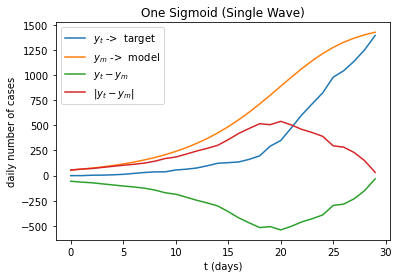

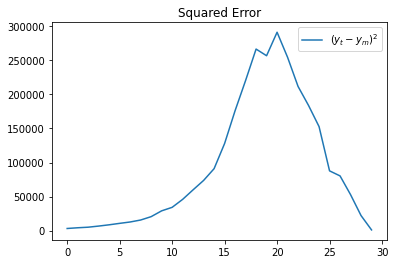

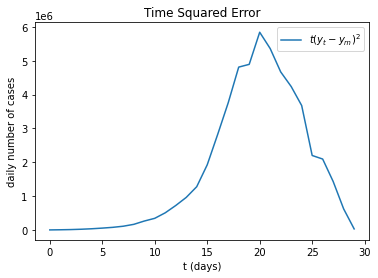

In [82]:
n_days = 30

# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_n_cases[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend()
plt.show()


In [83]:
# Integral Time Square Error (ITSE)

# Mean Squared Error (MSE)
def loss_f(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]
    
    y_t = acc_n_cases[:n_days]
    y_m = f_t(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def constr1(x):
    # delta >= 0
    return x[2]
def constr2(x):
    # nu >= 0
    return x[3]
def constr3(x):
    # A >= 0
    return x[0]

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}     
cons = [con1, con2, con3] 

In [84]:
A0 = 1500
tp0 = 20
delta0 = 3.1
nu0 = 2.2
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons,  method='SLSQP')
print(sol)

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 486.42483673890155
     jac: array([-1.52587891e-05,  9.56344604e-03, -9.07135010e-03, -2.18811035e-02])
 message: 'Optimization terminated successfully'
    nfev: 286
     nit: 50
    njev: 50
  status: 0
 success: True
       x: array([1.59789026e+03, 2.44616402e+01, 2.74128672e+00, 1.48467816e+00])


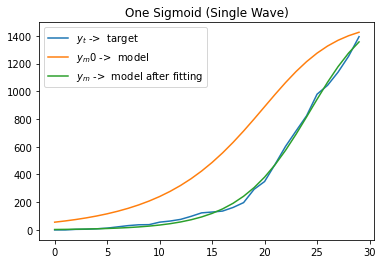

In [85]:
# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_n_cases[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.legend()
plt.show()

In [56]:
y_m

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

### Múltiplas ondas epidemiológicas

In [86]:
def loss_f(x):
    sigsum = np.zeros(n_days)
    for i in range(2):
        A = 1e5*x[i + 0]
        tp = 1e2*(i+1)
        delta = 50*x[i + 2]
        nu = x[i + 3]
        sigsum += f_t(t[:n_days], A, tp, delta, nu)
    y_t = acc_n_cases[:n_days]
    y_m = sigsum
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

In [87]:
loss_f(np.random.random((8, 1)))

299085.9580465736

In [88]:
from scipy.optimize import minimize
A0 = 3000
tp0 = 30
delta0 = 1.1
nu0 = 1.2
# print(f_t(t, A0, tp0, delta0, nu0))
#x0 = [A0, tp0, delta0, nu0]
x0 = np.random.random((8, 1))
sol = minimize(loss_f, x0, method='SLSQP')
print(sol)


     fun: 0.0
     jac: array([0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 11.86638194,   0.24214871,  11.72200435, -32.44316045,
         0.11193572,   0.97854484,   0.1391293 ,   0.79333591])


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


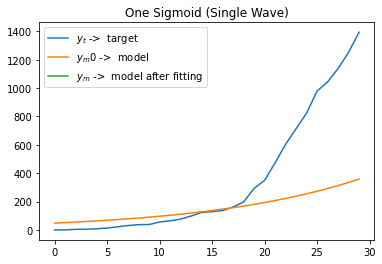

In [89]:
#[A, tp, delta, nu] = sol.x
x = sol.x
y_t = acc_n_cases[:n_days]
#y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
sigsum = np.zeros(n_days)
for i in range(2):
    A = 1e5*x0[i + 0]
    tp = 1e2*(i+1)
    delta = 50*x0[i + 2]
    nu = x0[i + 3]
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
y_m0 = sigsum
# y_m = f_t(t[:n_days], A, tp, delta, nu)
sigsum = np.zeros(n_days)
for i in range(2):
    A = 1e5*x[i + 0]
    tp = 1e2*(i+1)
    delta = 50*x[i + 2]
    nu = x[i + 3]
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
y_m = sigsum

plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.legend()
plt.show()

In [90]:
sigsum

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

### Fazendo testes com múltiplas ondas
Modelo envolvendo soma de sigmoides assimétricas 

In [91]:
n_sig = 4
x = np.random.rand(4*n_sig)
x

array([0.32453595, 0.99851428, 0.71052581, 0.88169267, 0.79389997,
       0.55383307, 0.03356844, 0.61154435, 0.3813226 , 0.59033607,
       0.14376463, 0.45117177, 0.69187765, 0.4272801 , 0.95279707,
       0.73670816])

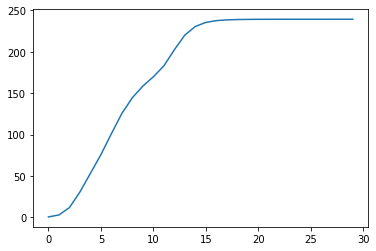

In [148]:
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 3*(i+1)
    delta = 2*x[i + 2]
    nu = x[i + 3]
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()